# Poincare Map
This example shows how to calculate a simple Poincare Map with REBOUND. A Poincare Map (or sometimes calles Poincare Section) can be helpful to understand dynamical systems.

In [1]:
import rebound
import numpy as np

We first create the initial conditions for our map. The most interesting Poincare maps exist near resonance, so we have to find a system near a resonance. The easiest way to get planets into resonance is migration. So that's what we'll do. Initially we setup a simulation in which the planets are placed just outside the 2:1 mean motion resonance.

In [2]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-3,a=1,e=0.001)
sim.add(m=0.,a=1.65)
sim.move_to_com()

We then define a simple migration force that will act on the outer planet. We implement it in python. This is relatively slow, but we only need to migrate the planet for a short time.

In [3]:
def migrationForce(reb_sim):
    tau = 40000.
    ps[2].ax -= ps[2].vx/tau
    ps[2].ay -= ps[2].vy/tau
    ps[2].az -= ps[2].vz/tau

Next, we link the additional migration forces to our REBOUND simulation and get the pointer to the particle array.

In [4]:
sim.additional_forces = migrationForce
ps = sim.particles

Then, we just integrate the system for 3000 time units, about 500 years in units where $G=1$.

In [5]:
sim.integrate(3000.)

Then we save the simulation to a binary file. We'll be reusing it a lot later to create the initial conditions and it is faster to load it from file than to migrate the planets into resonance each time. 

In [6]:
sim.save("resonant_system.bin") 

To create the poincare map, we first define which hyper surface we want to look at. Here, we choose the pericenter of the outer planet.

In [7]:
def hyper(sim):
    ps = sim.particles
    dx  = ps[2].x -ps[0].x
    dy  = ps[2].y -ps[0].y
    dvx = ps[2].vx-ps[0].vx
    dvy = ps[2].vy-ps[0].vy
    return dx*dvx + dy*dvy

We will also need a helper function that ensures our resonant angle is in the range $[-\pi:\pi]$.

In [8]:
def mod2pi(x):
    if x>np.pi:
        return mod2pi(x-2.*np.pi)
    if x<-np.pi:
        return mod2pi(x+2.*np.pi)
    return x

The following function generate the Poincare Map for one set of initial conditions. 
We first load the resonant system from the binary file we created earlier. 
We then randomly perturb the velocity of one of the particles. If we perturb the velocity enough, the planets will not be in resonant anymore.
We also initialize shadow particles to calculate the MEGNO, a fast chaos indicator.

In [9]:
def runone(args):
    i = args             # integer numbering the run
    N_points_max = 2000  # maximum number of point in our Poincare Section
    N_points = 0
    poincare_map = np.zeros((N_points_max,2))
    
    # setting up simulation from binary file
    sim = rebound.Simulation.from_file("resonant_system.bin")
    vx = 0.97+0.06*(float(i)/float(Nsim))
    sim.particles[2].vx *= vx
    sim.t = 0.            # reset time to 0
    
    # Integrate simulation in small intervals
    # After each interval check if we crossed the 
    # hypersurface. If so, bisect until we hit the 
    # hypersurface exactly up to a precision
    # of dt_epsilon
    dt = 0.13
    dt_epsilon = 0.001
    sign = hyper(sim)
    while sim.t<15000. and N_points < N_points_max:
        oldt = sim.t
        olddt = sim.dt
        sim.integrate(oldt+dt)
        nsign = hyper(sim)
        if sign*nsign < 0.:
            # Hyper surface crossed.
            leftt = oldt
            rightt = sim.t
            sim.dt = -olddt
            while (rightt-leftt > dt_epsilon):
                # Bisection.
                midt = (leftt+rightt)/2.
                sim.integrate(midt, exact_finish_time=1)
                msign = hyper(sim)
                if msign*sign > 0.:
                    leftt = midt
                    sim.dt = 0.3*olddt
                else:
                    rightt = midt
                    sim.dt = -0.3*olddt
            # Hyper surface found up to precision of dt_epsilon.
            # Calculate orbital elements
            o = sim.calculate_orbits()
            # Check if we cross hypersurface in one direction or the other.
            if o[1].r<o[1].a:
                # Calculate resonant angle phi and its time derivative 
                tp = np.pi*2.
                phi = mod2pi(o[0].l-2.*o[1].l+o[1].omega+o[1].Omega)
                phid = (tp/o[0].P-2.*tp/o[1].P)/(tp/o[0].P)
                # Store value for map
                poincare_map[N_points] = [phi,phid]
                N_points += 1
            sim.dt = olddt
            sim.integrate(oldt+dt)
        sign = nsign
    # Rerun to calculate Megno
    sim = rebound.Simulation.from_file("resonant_system.bin")
    vx = 0.97+0.06*(float(i)/float(Nsim))
    sim.particles[2].vx *= vx
    sim.t = 0.            # reset time to 0
    sim.init_megno(1e-16) # add variational (shadow) particles and calculate MEGNO
    sim.integrate(15000.)
    return (poincare_map, sim.calculate_megno(),vx)

For this example we'll run 10 initial conditions. Some of them will be in resonance, some other won't be. We run them in parallel using the InterruptiblePool that comes with REBOUND.

In [10]:
Nsim = 10
pool = rebound.InterruptiblePool()
res = pool.map(runone,range(Nsim))

Now we can finally plot the Poincare Map. We color the points by the MEGNO value of the particular simulation. A value close to 2 corresponds to quasi-periodic orbits, a large value indicate chaotic motion.

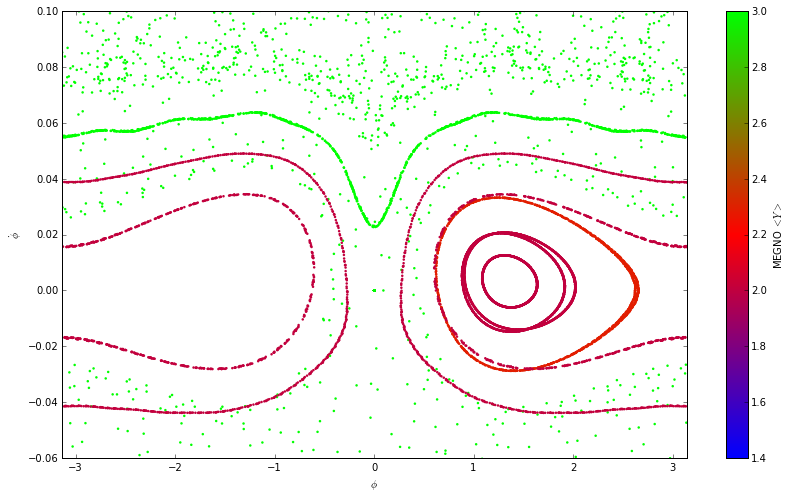

In [11]:
%matplotlib inline  
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,8))
ax = plt.subplot(111)
ax.set_xlabel("$\phi$"); ax.set_ylabel("$\dot{\phi}$")
ax.set_xlim([-np.pi,np.pi]); ax.set_ylim([-0.06,0.1])
cm = plt.cm.get_cmap('brg')
for m, megno, vx in res:
    c = np.empty(len(m[:,0])); c.fill(megno)
    p = ax.scatter(m[:,0],m[:,1],marker=".",c=c, vmin=1.4, vmax=3,  s=25,edgecolor='none',  cmap=cm)
cb = plt.colorbar(p, ax=ax)
cb.set_label("MEGNO $<Y>$")

The red orbits are periodic or quasi periodic, the green orbits are chaotic. 